<a href="https://colab.research.google.com/github/manthan-mehta/ImageClassification/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [0]:
def load_cifar10(cifar10_folder_path,batch_id):
  import pickle
  with open(cifar10_folder_path + '/data_batch_' +str(batch_id),'rb') as fo:
    dict = pickle.load(fo,encoding='latin1')
  return dict

In [0]:
train = None
Y_train = []
for i in range(1,6):
  dict1 = load_cifar10('/content',1)
  if i==1:
    train = dict1['data']
  else:
    train = np.vstack((train,dict1['data']))
  Y_train += dict1['labels']

In [0]:
X_train = train.reshape((len(train), 3, 32, 32)).transpose(0, 2, 3, 1)
Y_train = np.asarray(Y_train)

In [0]:
import pickle
with open('/content/test_batch','rb') as fo:
    test_data = pickle.load(fo,encoding='latin1')
X_test = test_data['data'].reshape((len(test_data['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
Y_test = np.asarray(test_data['labels'])

In [153]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
Y_val = Y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
Y_train = Y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
Y_dev = Y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
Y_test = Y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', Y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', Y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [154]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


In [0]:
mean_image = np.mean(X_train,axis=0)
mean_image = mean_image.astype('uint8')

In [0]:
X_train -= mean_image
X_dev -= mean_image
X_test -= mean_image
X_val -= mean_image

In [157]:
#Add Bias 
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [0]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

In [0]:
def svm_loss(x,y,w,reg):
  dw = np.zeros(w.shape)
  num_classes = w.shape[1]
  num_train = x.shape[0]
  scores = x.dot(w)
  correct_class_score = scores[np.arange(num_train),y].reshape(num_train,1)
  loss = 0.0
  local_loss = np.maximum(0,scores - correct_class_score + 1)
  local_loss[np.arange(num_train),y] = 0
  loss = local_loss.sum() / num_train
  loss += reg * np.sum(w*w)

  # Making all loss as 0 or 1 so that we can achieve https://math.stackexchange.com/questions/2572318/derivation-of-gradient-of-svm-loss
  local_loss[local_loss > 0] = 1
  count = local_loss.sum(axis = 1)
  local_loss[np.arange(num_train),y ] -= count
  dw = (x.T).dot(local_loss)
  dw = dw/num_train
  dw += reg*2*w
  return loss,dw;

In [160]:
loss,dw = svm_loss_1(W,X_dev,Y_dev,0.000005)
print('loss: %f' % (loss, ))

loss: 10.260829


In [161]:
import time
tic = time.time()
_, grad_vectorized = svm_loss(X_dev, Y_dev,W, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

Vectorized loss and gradient: computed in 0.017304s


In [0]:
class Linear_SVM(object):
  def __init__(self):
    self.W = None

  def train(self, X_train, Y_train, learning_rate, reg, num_iter, batch_size = 200, verbose = False):
    num_train,dim = X_train.shape
    num_class = np.max(Y_train) + 1
    if self.W is None:
      self.W = 0.001 * np.random.randn(dim,num_class)
    loss_history = []

    #stochastic gradient descent (batch wise)

    for it in range(num_iter):
      X_batch = None
      Y_batch = None
      
      batch_indices = np.random.choice(num_train, batch_size, replace=False)
      X_batch = X_train[batch_indices]
      Y_batch = Y_train[batch_indices]

      loss,grad = svm_loss(X_batch,Y_batch,self.W,reg)
      loss_history.append(loss)

      self.W = self.W - learning_rate * grad
      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iter, loss))

    return loss_history

  def predict(self,X):
    scores = X.dot(self.W)
    y_pred = np.zeros(X.shape[0])
    y_pred = np.argmax(scores,axis=1)
    return y_pred

In [0]:
classifier = Linear_SVM()
loss_history = classifier.train( X_train, Y_train, 1e-7,2.5e4,1500,256,False)

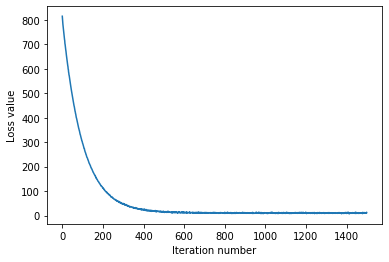

In [174]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [175]:
y_pred_train = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(Y_train == y_pred_train), ))

training accuracy: 0.149327


In [176]:
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(Y_val == y_val_pred), ))

validation accuracy: 0.153000


In [180]:
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4, 6e4]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

grid_search = [ (lr,rg) for lr in learning_rates for rg in regularization_strengths ]
for lr, rg in grid_search:
    # Create a new SVM instance
    svm = Linear_SVM()
    # Train the model with current parameters
    train_loss = svm.train(X_train, Y_train, learning_rate=lr, reg=rg,
                      num_iter=1500, verbose=False)
    # Predict values for training set
    y_train_pred = svm.predict(X_train)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == Y_train)
    # Predict values for validation set
    y_val_pred = svm.predict(X_val)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == Y_val)
    # Save results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_svm = svm
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.217286 val accuracy: 0.188000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.159796 val accuracy: 0.170000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.181735 val accuracy: 0.200000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.227388 val accuracy: 0.228000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.169020 val accuracy: 0.153000
lr 1.000000e-07 reg 4.500000e+04 train accuracy: 0.166020 val accuracy: 0.175000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.232490 val accuracy: 0.243000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 0.103347 val accuracy: 0.111000
lr 1.000000e-06 reg 2.000000e+04 train accuracy: 0.142245 val accuracy: 0.140000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.102898 val accuracy: 0.108000
lr 1.000000e-06 reg 3.000000e+04 train accuracy: 0.122408 val accuracy: 0.132000
lr 1.000000e-06 reg 3.500000e+04 train accuracy: 0.101449 val accuracy: 0.109000
lr 1.000000e-06 reg 4.000000

In [181]:
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(Y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.233000


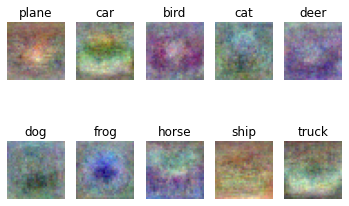

In [182]:
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])